# K-Nearest Neighbors (KNN) Implementation 
----
This code allows you to select a school district and locate its K nearest neighbors. 
 

## Importing packages, lists, and functions 

Importing Necessary Packages 

In [13]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram
import geopandas as gpd
import textwrap
from matplotlib.patches import ConnectionPatch
from scipy.spatial import Voronoi

Importing demographic buckets from other .py file (lists containing relevant columns to run algorithm on) 

In [14]:
os.chdir(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\4_Data_Modeling\4.2_KNN_Clustering")
from Demographic_Buckets import class_size_student_teacher_ratios
from Demographic_Buckets import student_mobility
from Demographic_Buckets import staff_demographics_experience
from Demographic_Buckets import race_ethnicity_percent
from Demographic_Buckets import economic_special_needs_percent
from Demographic_Buckets import language_education_percent
from Demographic_Buckets import gender_distribution_percent
from Demographic_Buckets import grade_level_percent
from Demographic_Buckets import special_populations_percent
from Demographic_Buckets import gifted_title1_percent
from Demographic_Buckets import district_identifiers

Importing functions from the .py file (containing all functions used for this analysis)

In [15]:
from KNN_Functions import calculate_missing_percentage
from KNN_Functions import find_nearest_districts
from KNN_Functions import plot_texas_districts
from KNN_Functions import plot_race_ethnicity_stacked_bar

## Reading in Data & Cleaning

Text(0.5, 1.0, 'Histogram of percentage of NA values in columns within demographic attributes')

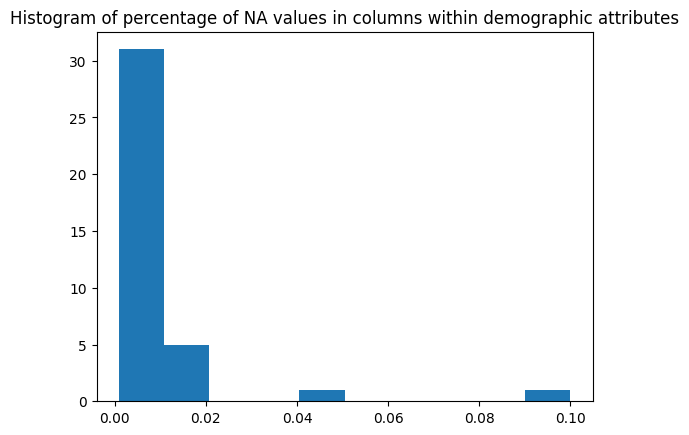

In [4]:
#Reading in the data
os.chdir(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\4_Data_Modeling\4.2_KNN_Clustering")
df = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.7Master_Files\Individual Year Files_Take2\merged_2023.csv")
distgrad = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.6Data2023\District\clean_data\distgrad_2023_clean.csv")
distprof = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.6Data2023\District\clean_data\distprof_2023_clean.csv")
df = df[df['Charter School (Y/N)'] == 'N']
demographic_df = df[class_size_student_teacher_ratios + student_mobility + staff_demographics_experience + race_ethnicity_percent +
                    economic_special_needs_percent + language_education_percent + gender_distribution_percent + grade_level_percent +
                    special_populations_percent + district_identifiers]

plt.hist(calculate_missing_percentage(demographic_df) / 100)
plt.title("Histogram of percentage of NA values in columns within demographic attributes")


Key takaways, the demographic data contains very few columns with a lot of NAs! The outcome oriented data on the other hand varies slightly. Regardless, the data science portion (fitting a knn model) will occur on mostly complete data

### KNN FUNCTION 


## Fitting model on Houston ISD to find 5 nearest neighbors for different distance metrics
---
Target District: Houston ISD (101912)  
Feature buckets used:   
* class_size_student_teacher_ratios  
* race_ethnicity_percent  
* staff_demographics_experience   


Number of Neighbors: 5   
Imputation Strategy: Median  


Distance Metric: euclidean
      DISTRICT_id        DISTNAME
532        101912     HOUSTON ISD
285         57905      DALLAS ISD
1040       220905  FORT WORTH ISD
850        171901       DUMAS ISD
524        101902      ALDINE ISD


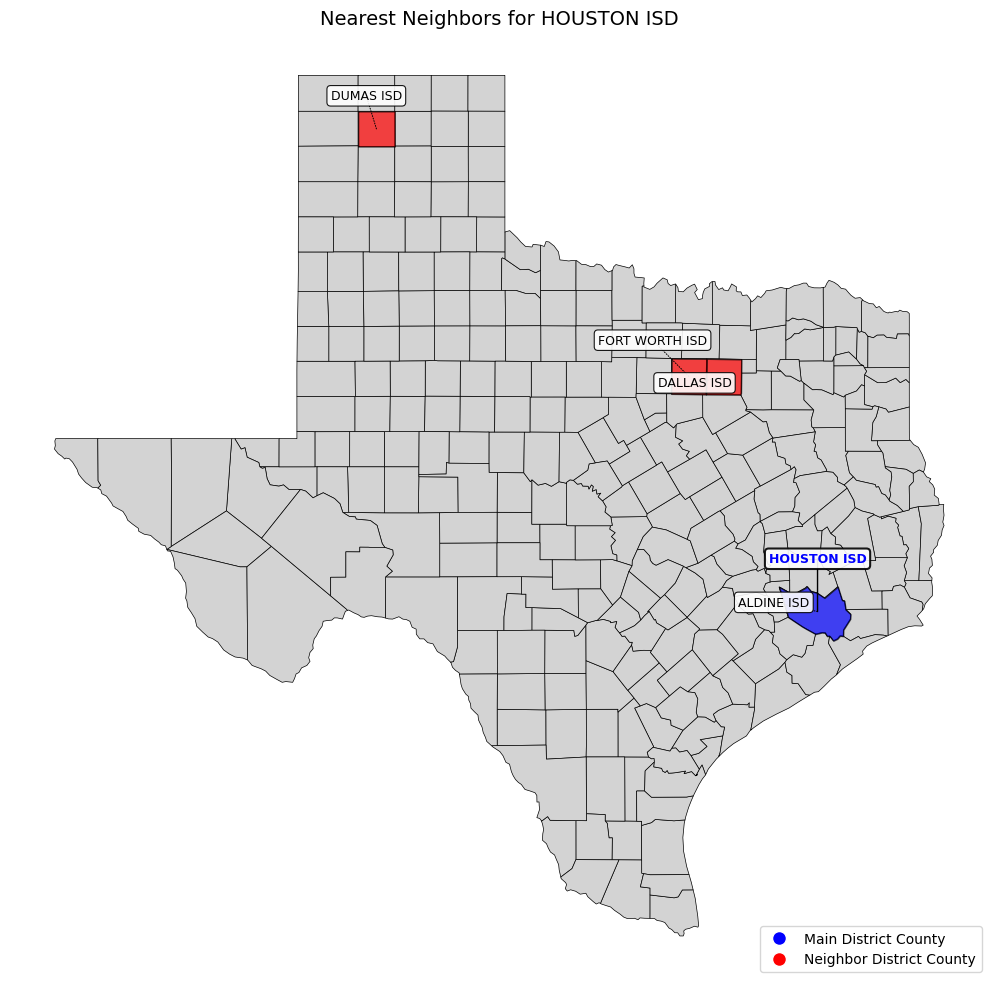

HOUSTON ISD


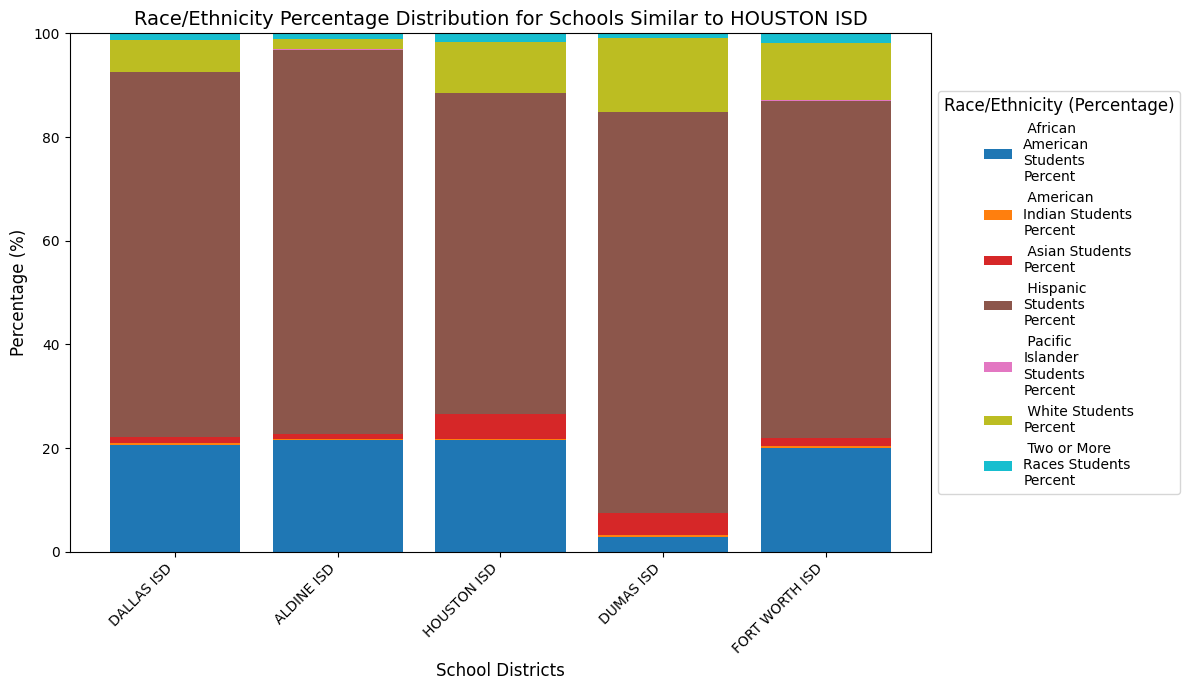

Distance Metric: manhattan
      DISTRICT_id        DISTNAME
532        101912     HOUSTON ISD
285         57905      DALLAS ISD
1040       220905  FORT WORTH ISD
418         84902   GALVESTON ISD
850        171901       DUMAS ISD


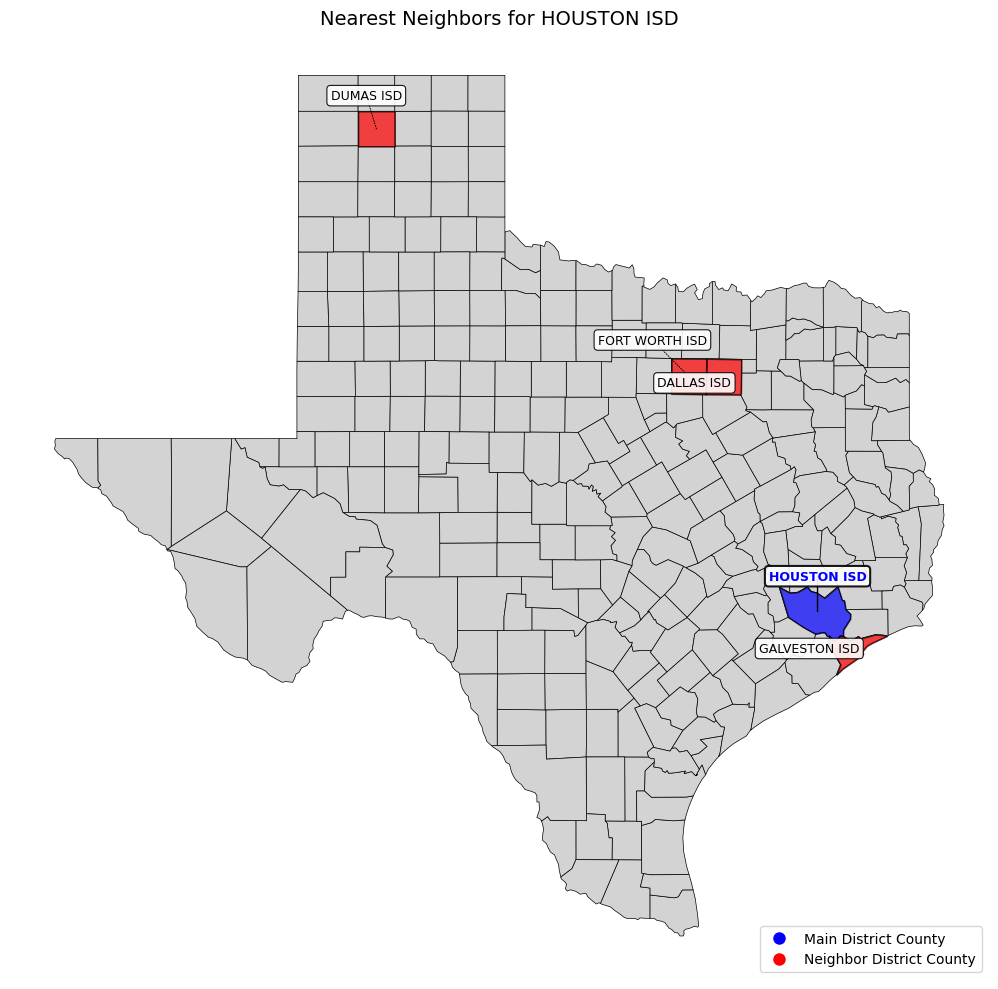

HOUSTON ISD


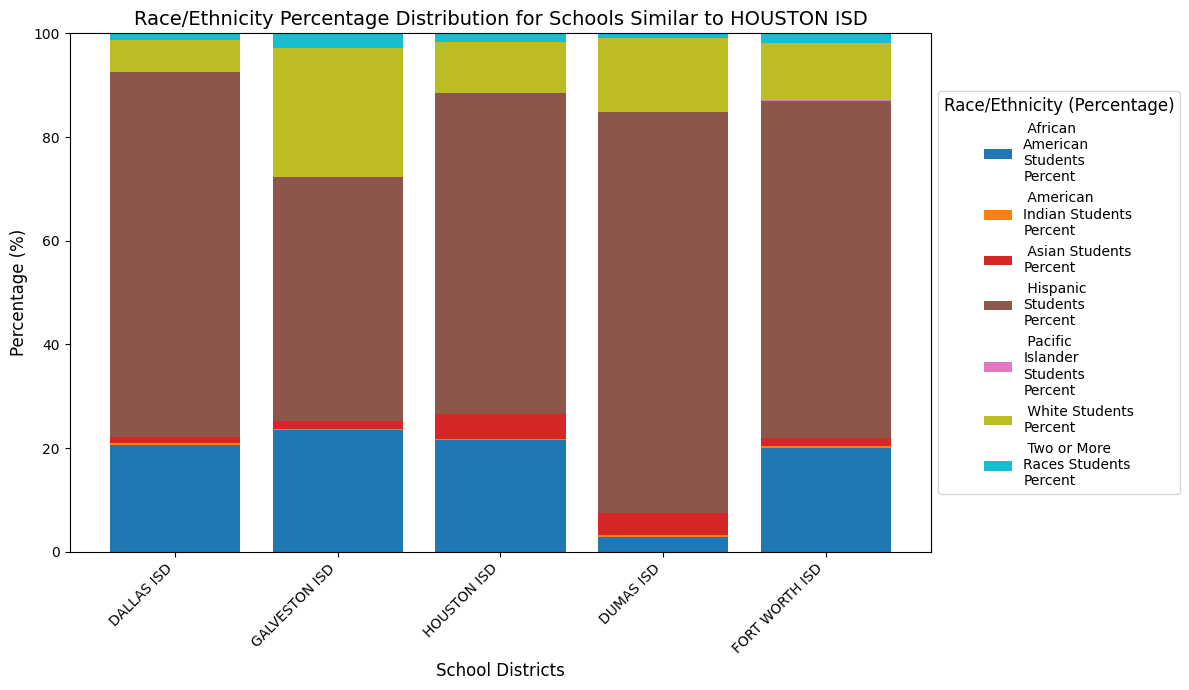

Distance Metric: mahalanobis
      DISTRICT_id           DISTNAME
532        101912        HOUSTON ISD
1040       220905     FORT WORTH ISD
418         84902      GALVESTON ISD
285         57905         DALLAS ISD
539        101920  SPRING BRANCH ISD


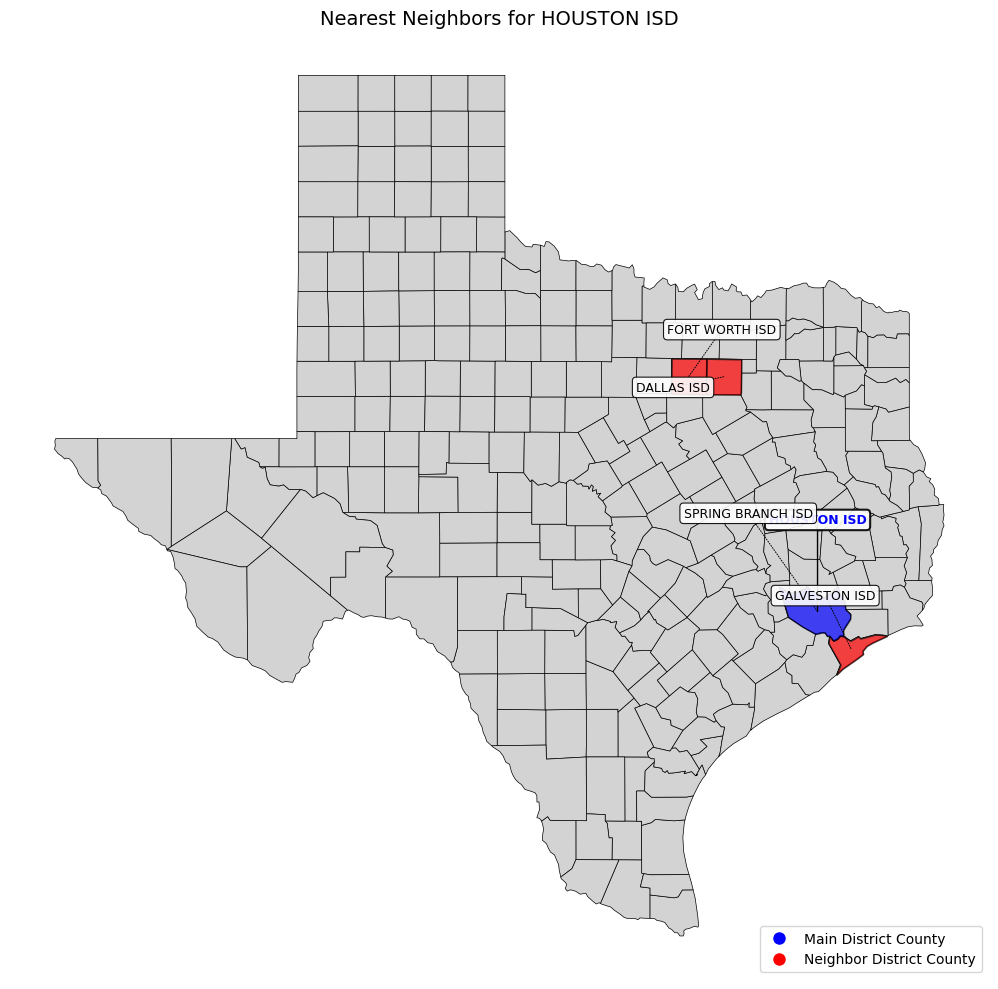

HOUSTON ISD


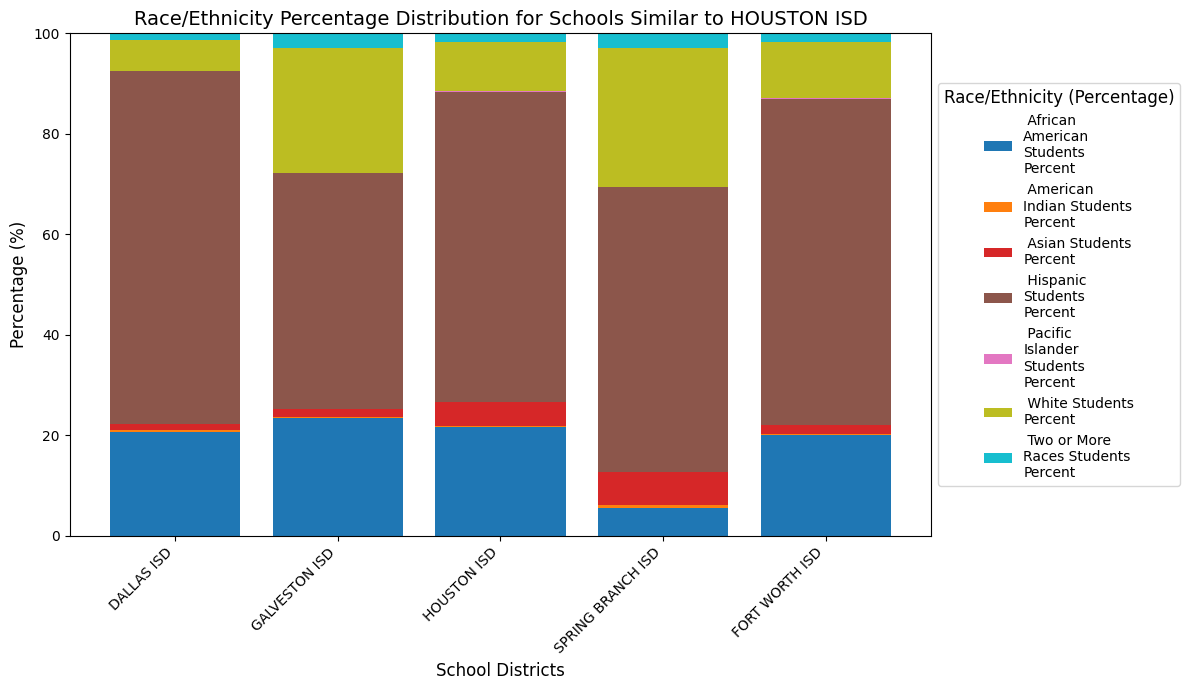

Distance Metric: cosine
[101912, 57905, 220905, 57910, 237902]


TypeError: list indices must be integers or slices, not str

In [5]:
distance_metrics = ['euclidean', 'manhattan', 'mahalanobis', 'cosine', 'canberra']
selected_features = race_ethnicity_percent + economic_special_needs_percent + grade_level_percent + special_populations_percent

for distance_metric in distance_metrics: 
    print(f"Distance Metric: {distance_metric}")
    knn_model = find_nearest_districts(df, 101912, selected_features, 5, distance_metric, "median")
    #knn_model = find_nearest_districts(df, 101912, selected_features, 5, distance_metric, "median")
    print(knn_model)
    plot_texas_districts(knn_model, df)
    plot_race_ethnicity_stacked_bar(knn_model, df)
    

In [16]:
knn_cosine = find_nearest_districts(df, 101912, selected_features, 5, "cosine", "median")



print(knn_cosine)
plot_texas_districts(knn_cosine, df)
plot_race_ethnicity_stacked_bar(knn_cosine, df)

[101912, 57905, 220905, 57910, 237902]


TypeError: list indices must be integers or slices, not str